In [1]:
#Import library yang diperlukan
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Fungsi load image digunakan untuk membaca file image dari path. Kemudian ubah image dari format Blue-Green-Red ke Gray.
def load_image(image_path):
  image = cv2.imread(image_path)
  if image is None:
    print('Error: Could not load image.')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image, gray

In [3]:
#Mencoba implementasi laod image dalam dataset. 
sample_image, sample_image_gray = load_image('images/George_W_Bush/1.jpg')

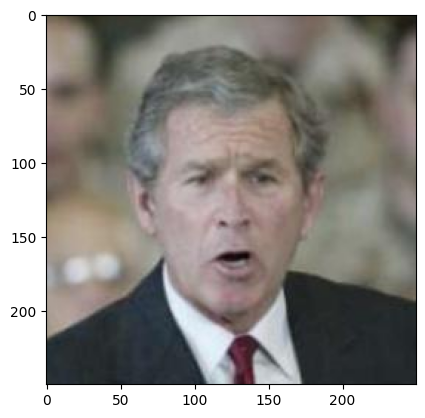

In [4]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

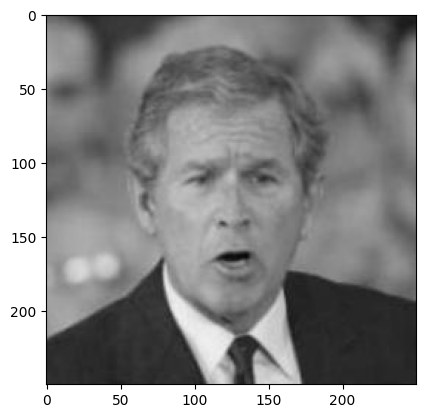

In [5]:
plt.imshow(cv2.cvtColor(sample_image_gray, cv2.COLOR_GRAY2RGB))

In [6]:
sample_image2, sample_image_gray2 = load_image('images/Mutiara_Setya/IMG_3681.jpg')

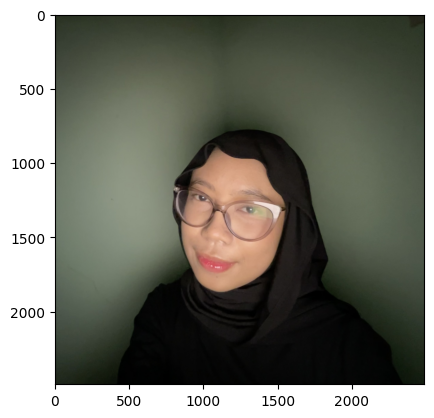

In [7]:
sample_image_rgb2 = cv2.cvtColor(sample_image2, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb2)

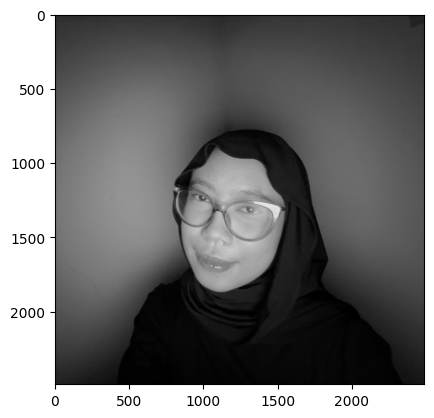

In [8]:
plt.imshow(cv2.cvtColor(sample_image_gray2, cv2.COLOR_GRAY2RGB))

In [9]:
#Muat seluruh images di dalam folder dataset dan konversi ke dalam format grayscale.
dataset_dir = 'images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image_gray = load_image(os.path.join(root, f))
    if image_gray is None:
      continue
    images.append(image_gray)
    labels.append(root.split('/')[-1])

In [10]:
len(labels)

70

In [11]:
#Muat model Haar Cascade untuk deteksi wajah frontal.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [12]:
#Deteksi wajah pada citra grayscale berdasarkan skala dan ukuran minimum wajah
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5,
min_size=(30, 30)):
  faces = face_cascade.detectMultiScale(
      image_gray,
      scaleFactor=scale_factor,
      minNeighbors=min_neighbors,
      minSize=min_size
  )
  return faces

In [13]:
sample_faces = detect_faces(sample_image_gray, min_size=(50,0))

In [14]:
sample_faces2 = detect_faces(sample_image_gray2, min_size=(50,0))

In [15]:
#Fungsi untuk crop wajah berdasarkan bounding box 
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces
#return crop wajah dan koordinatnya

In [16]:
cropped_faces, _ = crop_faces(sample_image_gray, sample_faces)

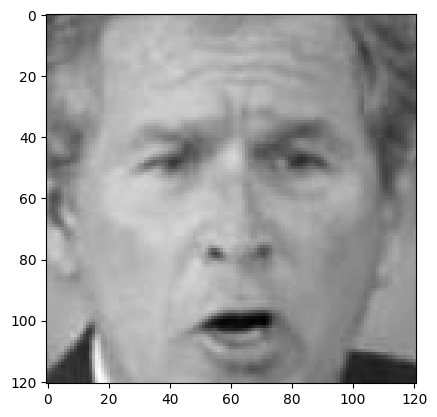

In [17]:
plt.imshow(cropped_faces[0], cmap='gray')

In [18]:
cropped_faces2, _ = crop_faces(sample_image_gray2, sample_faces2)

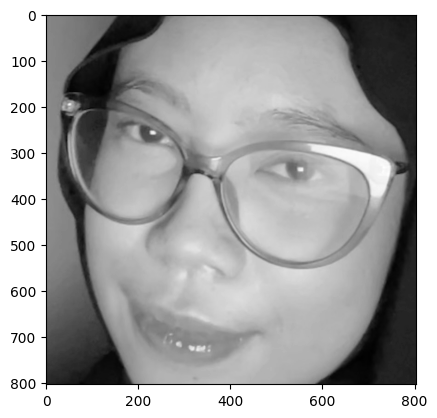

In [19]:
plt.imshow(cropped_faces2[0], cmap='gray')

In [20]:
#Ubah ukuran wajah menjadi 128x128 dan ubah jadi vektor satu dimensi
face_size = (128, 128)
def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

In [21]:
#ubah ukuran dan ubah wajah jadi vektor fitur dan disimpan dalam x serta y
X = []
y = []

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [22]:
y.shape

(70,)

In [23]:
#bagi dataset x dan y untuk train (70%) dan test (30%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y) 

In [24]:
#hitung vektor rerata wajah kemudian mengurangkan vektor rerata untuk mean centering
from sklearn.base import BaseEstimator, TransformerMixin 

class MeanCentering(BaseEstimator, TransformerMixin): 
  def fit(self, X, y=None): 
    self.mean_face = np.mean(X, axis=0) 
    return self 
  
  def transform(self, X): 
    return X - self.mean_face 

In [25]:
#membuat pipeline dengan mean centering, reduksi dimensi, dan klasifikasi menggunakan SVM
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC 
from sklearn.decomposition import PCA 

pipe = Pipeline([ 
  ('centering', MeanCentering()), 
  ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)), 
  ('svc', SVC(kernel='linear', random_state=177)) 
])

In [26]:
#latih data dan test data kemudian mencetak metriknya
from sklearn.metrics import classification_report 
 
pipe.fit(X_train, y_train) 
 
y_pred = pipe.predict(X_test) 
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

   images\Bill_Clinton       0.67      0.67      0.67         3
  images\George_W_Bush       0.33      0.33      0.33         3
images\Jennifer_Garner       1.00      0.67      0.80         3
     images\Laura_Bush       0.60      1.00      0.75         3
  images\Mutiara_Setya       1.00      1.00      1.00         3
images\Serena_Williams       0.75      1.00      0.86         3
 images\Vladimir_Putin       1.00      0.33      0.50         3

              accuracy                           0.71        21
             macro avg       0.76      0.71      0.70        21
          weighted avg       0.76      0.71      0.70        21



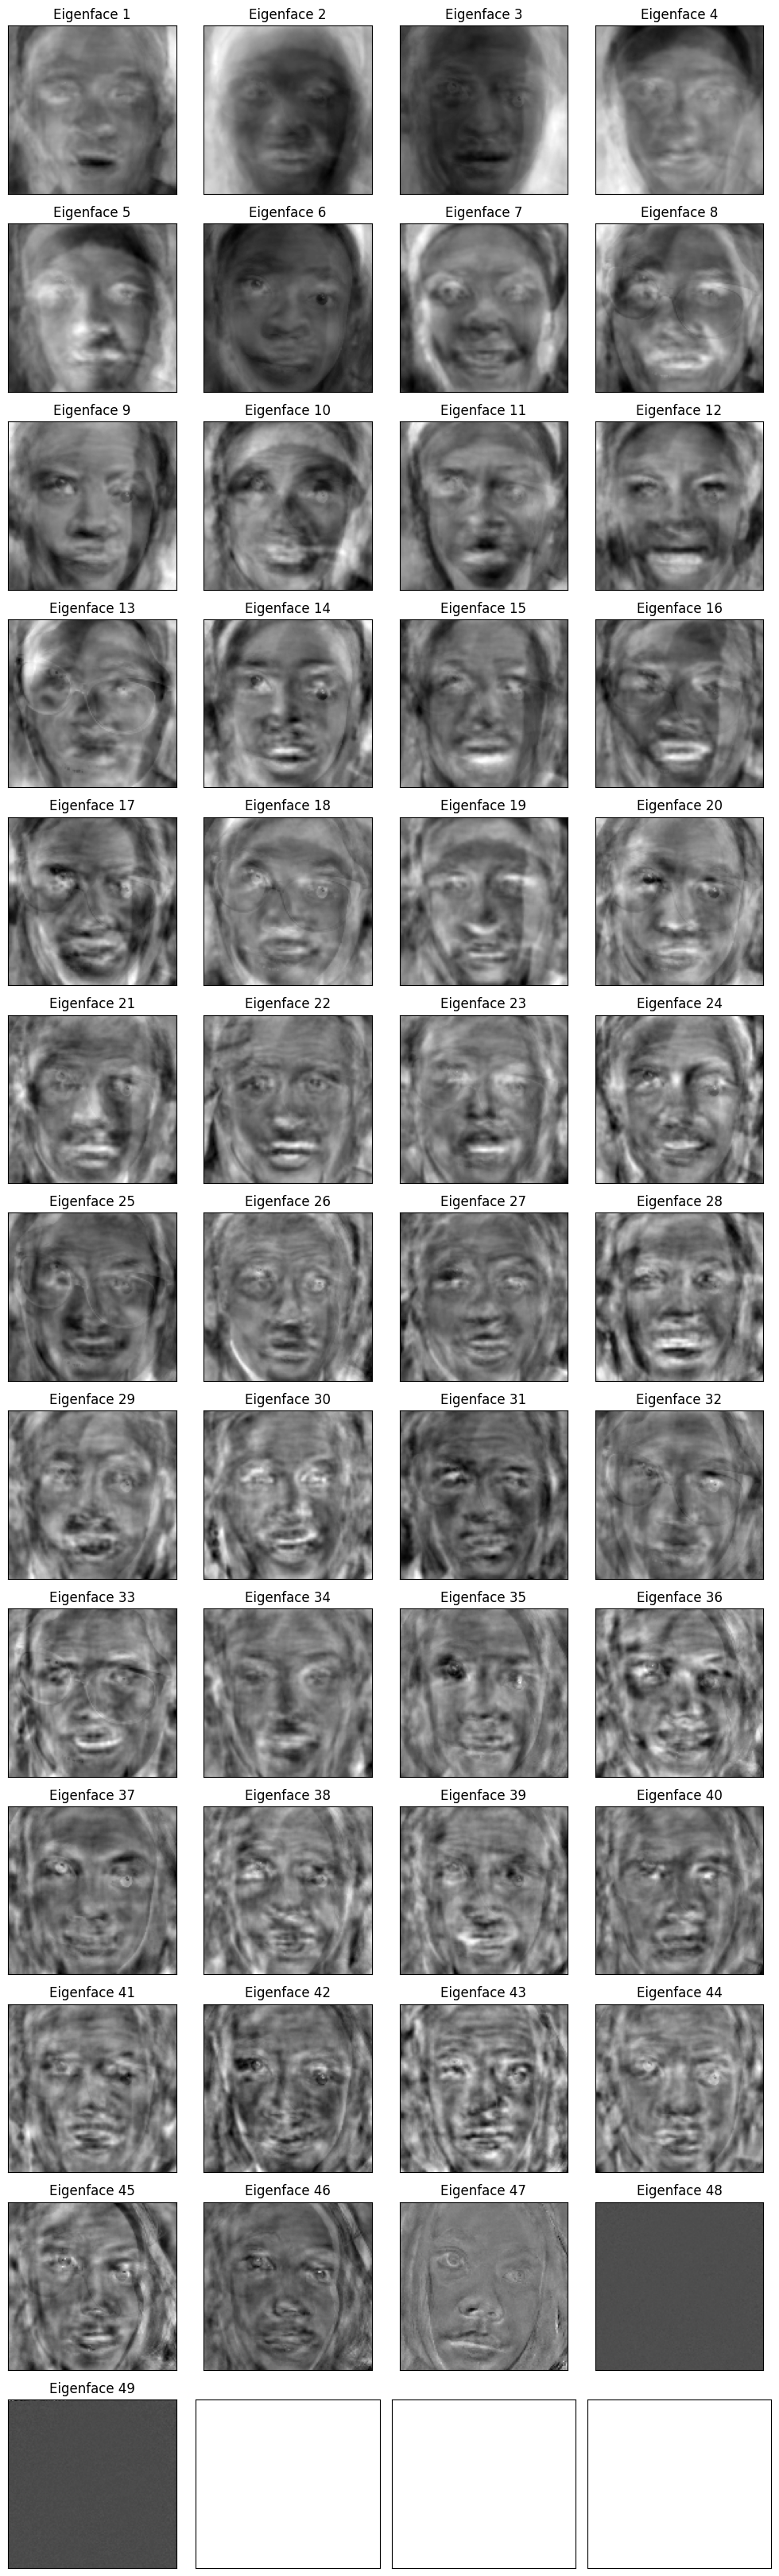

In [27]:
#hitung jumlah baris, reshape komponen menjadi ukuran wajah, gambar di setiap subplot
n_components = len(pipe[1].components_) 

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5 * nrow), subplot_kw={'xticks': [], 'yticks': []})

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))

for i, ax in enumerate(axes.flat):
    if i < n_components:  #Pastikan tidak mengakses indeks yang lebih besar dari n_components
        ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
        ax.set_title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()


In [28]:
#menyimpan objek pipeline
import pickle 
 
with open('eigenface_pipeline.pkl', 'wb') as f: 
    pickle.dump(pipe, f) 

In [29]:
#menghitung skor SVM dan return nilai max sebagai skor eigenface
def get_eigenface_score(X): 
  X_pca = pipe[:2].transform(X) 
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1) 
  return eigenface_scores 

In [30]:
#mengembalikan komponen skor, label, boounding box wajah yang terdeteksi
def eigenface_prediction(image_gray): 
    faces = detect_faces(image_gray) 
    cropped_faces, selected_faces = crop_faces(image_gray, faces) 
     
    if len(cropped_faces) == 0: 
        return 'No face detected.' 
     
    X_face = [] 
    for face in cropped_faces: 
        face_flattened = resize_and_flatten(face) 
        X_face.append(face_flattened)
    X_face = np.array(X_face) 
    labels = pipe.predict(X_face) 
    scores = get_eigenface_score(X_face) 
     
    return scores, labels, selected_faces 

In [31]:
#gambar box dan tuliskan label serta skor prediksi di atas citra
def draw_text(image, label, score, 
              font=cv2.FONT_HERSHEY_SIMPLEX, 
              pos=(0, 0), 
              font_scale=0.6, 
              font_thickness=2, 
              text_color=(0, 0, 0), 
              text_color_bg=(0, 255, 0) 
              ): 
 
  x, y = pos 
  score_text = f'Score: {score:.2f}' 
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, 
                                font_thickness) 
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale, 
                                font_thickness) 
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), 
                text_color_bg, -1) 
  cv2.putText(image, label, (x+10, y-10), font, font_scale, 
              text_color, font_thickness) 
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, 
              text_color, font_thickness) 

In [32]:
#buat copy gambar dan menggambar bounding box serta tabel
def draw_result(image, scores, labels, coords): 
  result_image = image.copy() 
  for (x, y, w, h), label, score in zip(coords, labels, scores): 
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    draw_text(result_image, label, score, pos=(x, y)) 
  return result_image 

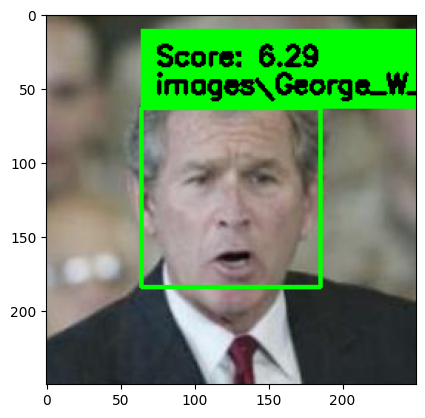

In [33]:
#iimplementasi code pada image dataset
scores, labels, selected_faces = eigenface_prediction(sample_image_gray)

result_image = draw_result(sample_image_rgb, scores, labels, selected_faces)

plt.imshow(result_image)

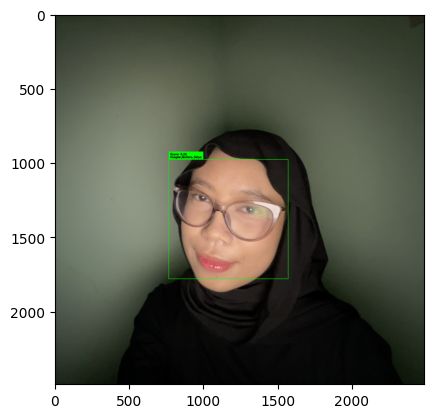

In [34]:
scores, labels, selected_faces = eigenface_prediction(sample_image_gray2)

result_image = draw_result(sample_image_rgb2, scores, labels, selected_faces)

plt.imshow(result_image)

In [35]:
#koneksi ke webcam
cap = cv2.VideoCapture(0)

#Loop terus-menerus untuk membaca frame dari webcam
while True:
    #Baca satu frame dari webcam
    ret, frame = cap.read()
    if not ret:
        break

    #Ubah frame BGR ke grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #Deteksi wajah dalam frame grayscale
    faces = detect_faces(gray_frame)
    
    #Jika satu atau lebih wajah terdeteksi
    if len(faces) > 0:
        #Potong wajah-wajah yang terdeteksi
        cropped_faces, selected_faces = crop_faces(gray_frame, faces)
        #Lakukan prediksi eigenface (label + skor) pada frame grayscale
        scores, labels, selected_faces = eigenface_prediction(gray_frame)
        #Gambar bounding box, label, dan skor pada frame asli
        result_frame = draw_result(frame, scores, labels, selected_faces)
        #Tampilkan frame hasil anotasi
        cv2.imshow('Webcam', result_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
